In [18]:
import numpy as np
from z3 import *
from itertools import product, groupby
from sympy import primerange
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [19]:
board = np.array([[ 0, 0, 0, 1, 1, 1, 3, 3, 5, 5, 5],
                  [ 0, 2, 2, 2, 1, 1, 3, 5, 5, 5, 6],
                  [ 0, 2, 2, 1, 1, 1, 3, 5, 5, 5, 6],
                  [ 0, 2, 2, 1, 1, 4, 4, 5, 6, 6, 6],
                  [ 0, 2, 1, 1, 5, 5, 4, 5, 6, 7, 6],
                  [ 0, 5, 5, 5, 5, 5, 5, 5, 7, 7,12],
                  [ 8, 5, 5, 5, 5,10,10, 5, 7, 7, 7],
                  [ 8, 8, 9, 5, 9,10,10, 5, 5, 7, 5],
                  [ 8, 8, 9, 9, 9,10,10, 5, 5, 5, 5],
                  [ 8, 9, 9, 8, 8, 8,10, 5, 5, 5,11],
                  [ 8, 8, 8, 8, 8,10,10,10, 5, 5,11]], dtype=int)


def plot_model_with_annotations(model, X, N, board):
    arr = np.zeros((N,N), dtype=int)
    for i,j in product(range(N), repeat=2):
        arr[i][j] = model.eval(X[i][j]).as_long()
            
    total = 0
    for row in arr:
        groups = ["".join(str(x) for x in group) for key,group in groupby(row, lambda x: x==-1) if not key]
        total += sum([int(group) for group in groups])

    unique_values = np.unique(board)
    color_map_index = {val: idx for idx,val in enumerate(unique_values)}
    cmap = plt.get_cmap('Spectral', len(unique_values))
    norm = plt.Normalize(0, len(unique_values) - 1)
    color_array = cmap(norm([color_map_index[val] for val in board.ravel()])) 
    color_array = color_array.reshape(board.shape + (4,))

    mask = arr==-1
    color_array[mask] = [0, 0, 0, 1]
    _, ax = plt.subplots(figsize=(10, 10))
    _ = ax.imshow(color_array, vmin=0, vmax=1)

    for i,j in product(range(N), repeat=2):
        label = '' if arr[i][j] == -1 else str(arr[i][j])
        ax.text(j, i, label, va='center', ha='center', color='white' if mask[i][j] else 'black')

    ax.set_xticks(np.arange(-.5, N, 1), minor=False)
    ax.set_yticks(np.arange(-.5, N, 1), minor=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='major', color='black', linestyle='-', linewidth=2)
    plt.grid(True)
    plt.show()
    display(Markdown('### Answer is: {:,.0f}'.format(total)))

In [20]:
orthagonal = lambda i, j, N: [(i+dx, j+dy) for dx,dy in [(-1,0), (1,0), (0,-1), (0,1)] if 0<=i+dx<N and 0<=j+dy<N]
vertical = lambda i, j, N: [(i+dx, j+dy) for dx,dy in [(-1,0), (1,0)] if 0<=i+dx<N and 0<=j+dy<N]

def generate_arrays() -> list[tuple]:
    meets_conditions = lambda arr: arr[1] != -1 and arr[-2] != -1 and \
        all(not (arr[i] == -1 and arr[i + 2] == -1) for i in range(len(arr) - 2)) and \
            all(not (arr[i] == -1 and arr[i + 1] == -1) for i in range(len(arr) - 1))
    return [arr for arr in product([-1, 0], repeat=11) if meets_conditions(arr)]

def prime_powers() -> list[int]:
    prime_powers = set[int]()
    for base,power in product(list(primerange(2, 10**6)), list(primerange(2, 30))):
        if (num:=base**power) < 10**12:
            prime_powers.add(num)
    return list(prime_powers)

all_prime_powers = prime_powers()
all_row_arrangements = generate_arrays()

index_groups_zero = lambda tup: list[tuple]([tuple(idx for idx,_ in group) for key,group in groupby(enumerate(tup), lambda x: x[1] == 0) if key])
row_arrangement_zero_group_indicies = dict[tuple, list[tuple]]({tup: index_groups_zero(tup) for tup in all_row_arrangements})

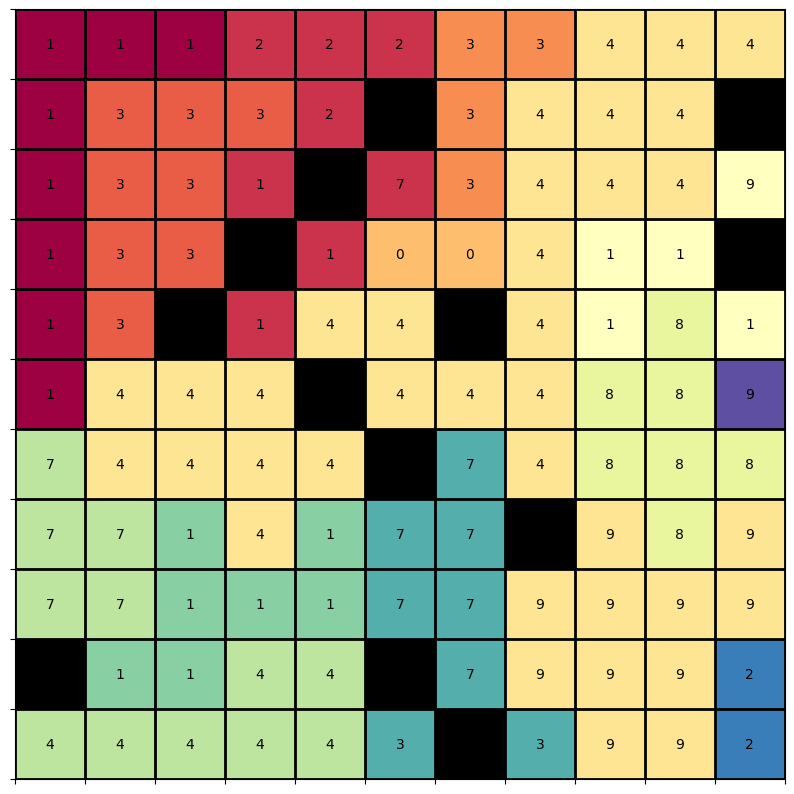

### Answer is: 88,243,711,283

In [35]:
s = Solver()
N = len(board)
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N))


# general rules
# all of the numbers are between -1 and 9 (-1 is how we represent the blocks)
s += [And(n>=-1, n<=9) for n in X.ravel()]
# if in the same group and orthagonal either has to be the same number or one of them is a block
s += [Or(X[i][j]==X[k][l], Xor(X[i][j]==-1, X[k][l]==-1)) if board[k][l]==board[i][j] else X[i][j]!=X[k][l] 
      for i,j in product(range(N), repeat=2) 
      for k,l in orthagonal(i, j, N)]
# blocks cannot touch each other vertically (horizontally is already covered)
s += [Implies(X[i][j]==-1, X[k][l]!=-1) for i,j in product(range(1, N-1), range(N)) for k,l in vertical(i, j, N)]


valid_section = lambda row, tup: And([If(val==0, X[row][c]>=0, X[row][c]==-1) for c,val in enumerate(tup)])
concat_number = lambda row, group: Sum([X[row][tup_idx]*10**(len(group)-idx-1) for idx,tup_idx in enumerate(group)])
multiple_of = lambda row, group, n: concat_number(row, group) % n == 0
palindrome = lambda row, group: And([X[row][tup_idx]==X[row][group[-(idx+1)]] for idx,tup_idx in enumerate(group[:len(group)//2])])
perfect_square = lambda n: ToInt(n**0.5) == n**0.5
fibonacci = lambda n: Or(perfect_square(5*n*n+4), perfect_square(5*n*n-4))
ends_in = lambda row, numbers: And(And([Implies(X[row][c]==-1, Or([X[row][c-1]==n for n in numbers])) for c in range(2, N)]), 
                                   Or([X[row][-1]==n for n in numbers+[-1]]))
cant_end_in = lambda row, numbers: And(And([Implies(X[row][c]==-1, And([X[row][c-1]!=n for n in numbers])) for c in range(2, N)]), 
                                       And([X[row][-1]!=n for n in numbers]))
can_only_be = lambda row, numbers: And([Or([X[row][c]==n for n in numbers+[-1]]) for c in range(N)])
cant_be = lambda row, numbers: And([X[row][c]!=n for n in numbers for c in range(N)])


############################################################################################################
# square, row 0
#  it can only end in 0, 1, 4, 5, 6, or 9 and the first group has to be at least length 3
s += ends_in(0, [0, 1, 4, 5, 6, 9])
s += Or([And(valid_section(0, tup),
             And([perfect_square(concat_number(0, group)) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements
         if len(row_arrangement_zero_group_indicies[tup][0])>=3])
############################################################################################################
############################################################################################################
# 1 more than a palindrome, row 1
# FIXME palindrome edge case with 9s
# we know that the first group either has to be between 3 and 5
s += Or([And(valid_section(1, tup), 
             And([And([palindrome(1, group[1:-1])] + [X[1][group[-1]] == X[1][group[0]] + 1]) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements
         if 3<=len(row_arrangement_zero_group_indicies[tup][0])<=5])
############################################################################################################
############################################################################################################
# prime raised to a prime power, row 2
s += Or([And(valid_section(2, tup),
                And([Or([concat_number(2, group)==prime_power for prime_power in all_prime_powers 
                         if len(str(prime_power))==len(group)])
                     for group in row_arrangement_zero_group_indicies[tup]])) 
          for tup in all_row_arrangements])
############################################################################################################
############################################################################################################
# sum of digits is 7, row 3
# there needs to be at least 2 groups here and the numbers need to be <= 7
s += cant_be(3, [8, 9])
s += Or([And(valid_section(3, tup), 
             And([Sum([X[3][tup_idx] for tup_idx in group]) == 7 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements
         if len(row_arrangement_zero_group_indicies[tup])>=2])
############################################################################################################
############################################################################################################
# fibonacci, row 4
s += Or([And(valid_section(4, tup), 
             And([fibonacci(concat_number(4, group)) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements])
############################################################################################################
############################################################################################################
# square, row 5
# can only end in 0, 1, 4, 5, 6, or 9 and we know at least one has to be at least length 4
s += ends_in(5, [0, 1, 4, 5, 6, 9])
s += Or([And(valid_section(5, tup),
             And([perfect_square(concat_number(5, group)) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements
         if any([len(group)>=4 for group in row_arrangement_zero_group_indicies[tup]])])
############################################################################################################
############################################################################################################
# multiple of 37, row 6
s += Or([And(valid_section(6, tup), 
             And([multiple_of(6, group, 37) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements])
############################################################################################################
############################################################################################################
# palindrome multiple of 23, row 7
# cannot have a palindrom multiple of 23 be 2 digits and since it can't start with 0 it can't end with 0
s += cant_end_in(7, [0])
s += Or([And(valid_section(7, tup),
             And([multiple_of(7, group, 23) 
                  for group in row_arrangement_zero_group_indicies[tup]]),
             And([palindrome(7, group) 
                  for group in row_arrangement_zero_group_indicies[tup]]))
         for tup in all_row_arrangements 
         if all([len(group) > 2 for group in row_arrangement_zero_group_indicies[tup]])])
############################################################################################################
############################################################################################################
# product of digits ends in 1, row 8
# can only be blocks or 1, 3, 7, or 9
s += can_only_be(8, [1, 3, 7, 9])
s += Or([And(valid_section(8, tup),
             And([Product([X[8][tup_idx] for tup_idx in group]) % 10 == 1 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements])
############################################################################################################
############################################################################################################
# multiple of 88, row 9
s += ends_in(9, [0, 2, 4, 6, 8])
s += Or([And(valid_section(9, tup), 
             And([multiple_of(9, group, 88) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements])
############################################################################################################
############################################################################################################
# 1 less than a palindrome, row 10
# FIXME palindrome edge case with 9s
# we know that the first group has to be either length 5 or 6 
# and there has to be 2 groups because of the 88 constraint so we can force one block
# and we know the second group is either 3 or 4 in length
s += X[-1][6]==-1
s += Not(Distinct([X[-1][c] for c in range(1,5)]))
s += X[-1][5]==X[-1][4]-1
s += Or([And(valid_section(10, tup), 
             And([And([palindrome(10, group[1:-1])] + [X[10][group[-1]] == X[10][group[0]] - 1]) 
                  for group in row_arrangement_zero_group_indicies[tup]])) 
         for tup in all_row_arrangements 
         if len(row_arrangement_zero_group_indicies[tup])==2 
         and len(row_arrangement_zero_group_indicies[tup][0]) in [5, 6] 
         and len(row_arrangement_zero_group_indicies[tup][-1]) in [3, 4]])
############################################################################################################


# manual
# FIXME it should not need this to run in theory
s += And([X[0][c]!=-1 for c in range(N)])
s += And([X[1][c]==v for c,v in enumerate([1,3,3,3,2,-1,3,4,4,4,-1])])
s += And([X[2][c]==v for c,v in enumerate([1,3,3,1,-1,7,3,4,4,4,9])])
s += And([X[4][c]==v for c,v in enumerate([1,3,-1,1,4,4,-1,4,1,8,1])])
s += And([X[5][c]==v for c,v in enumerate([1,4,4,4,-1,4,4,4,8,8,9])])


if s.check() == sat:
    m = s.model()
    plot_model_with_annotations(m, X, N, board)